In [62]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

import sys
sys.path.append("..")

from torch.utils.data import DataLoader

from bridge.rnn.datasets import BidDataset
from bridge.rnn.models import HandsClassifier

In [80]:
# dataset = BidDataset("../data/human/valid.txt")
dataset = BidDataset("../data/test.txt")
dataset

In [81]:
loader = DataLoader(dataset, batch_size=256)
loader

In [82]:
# model = HandsClassifier.load_from_checkpoint("../ckpt/hands/20220602_0740/hands-epoch=40-valid_card_acc=0.46-valid_loss=0.28.ckpt").cuda()
# model = HandsClassifier.load_from_checkpoint("../ckpt/hands/20220605_2200/hands-epoch=12-valid_card_acc=0.47-valid_loss=0.26.ckpt").cuda()
model = HandsClassifier.load_from_checkpoint("../ckpt/hands/20220606_1530/hands-epoch=12-valid_card_acc=0.53-valid_loss=0.25.ckpt").cuda()
model

HandsClassifier(
  (gru): GRU(36, 36, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=280, out_features=208, bias=True)
  )
  (sigmoid): Sigmoid()
  (loss): BCELoss()
)

In [83]:
from tqdm import tqdm
import torch

hints = []
# results = []
hinted_results = []
# null_results = []
random_results = []
targets = []
biddings = []
with torch.no_grad():
    for masked_hand, bidding, length, target in tqdm(loader):
        masked_hand = masked_hand.cuda()
        biddings.append(bidding)
        bidding = bidding.cuda()
        output = model(masked_hand, bidding, length)
        hints.append(masked_hand.cpu())
        targets.append(target)
        # results.append(model.greedy_generate(output.cpu()))
        hinted_results.append(model.greedy_generate(output.cpu(), hints=masked_hand.cpu()))
        # null_results.append(model.greedy_generate(torch.zeros(output.shape), hints=masked_hand.cpu()))
        random_results.append(model.greedy_generate(torch.rand(output.shape), hints=masked_hand.cpu()))
hints = torch.concat(hints)
targets = torch.concat(targets)
# results = torch.concat(results)
hinted_results = torch.concat(hinted_results)
# null_results = torch.concat(null_results)
random_results = torch.concat(random_results)
biddings = torch.concat(biddings)

100%|██████████| 40/40 [00:37<00:00,  1.07it/s]


In [84]:
# print(f"Result: {model.get_accuracy(results, targets)}")
print(f"Hinted Result: {model.get_accuracy(hinted_results, targets)}")
print(f"Hinted Result (out of hints): {model.get_accuracy(hinted_results, targets, hints=hints)}")
# print(f"Null Result: {model.get_accuracy(null_results, targets)}")
# print(f"Null Result (out of hints): {model.get_accuracy(null_results, targets, hints=hints)}")
print(f"Random Result: {model.get_accuracy(random_results, targets)}")
print(f"Random Result (out of hints): {model.get_accuracy(random_results, targets, hints=hints)}")

Hinted Result: (0.6575961709022522, 0.375900000333786, 0.0)
Hinted Result (out of hints): (0.45136383175849915, 0.0, 0.0)
Random Result: (0.6266441941261292, 0.375900000333786, 0.0)
Random Result (out of hints): (0.4017693102359772, 0.0, 0.0)


In [85]:
both_selected = (hinted_results == 1) & (targets == 1)
match = hinted_results == targets

zero_hints = hints.clone()
zero_hints[zero_hints < 0] = 0
hand_both_selected = torch.stack(both_selected.split(52, dim=1))
hand_hints = (torch.stack(zero_hints.split(52, dim=1)).sum(dim=2) == 13)
card_acc = (hand_both_selected[~hand_hints].sum(dim=1).float().mean() / 13).item()
hand_acc = torch.stack(match.split(52, dim=1)).all(dim=2)[~(torch.stack(zero_hints.split(52, dim=1)).sum(dim=2) == 13)].float().mean().item()
card_acc, hand_acc

(0.45136383175849915, 0.0)

In [86]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.style.use('ggplot')

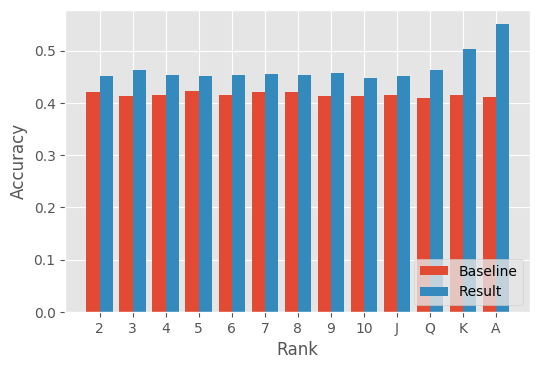

In [87]:
import numpy as np
ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']

width = .4

card_unknown = torch.stack((torch.stack((hints == 0).split(52, dim=1)).sum(dim=0) > 0).split(13, dim=1))

plt.figure(dpi=100)
plt.bar(
    np.arange(13),
    ((torch.stack((torch.stack((random_results == targets).split(52, dim=1)).sum(dim=0) == 4).split(13, dim=1)) & card_unknown).sum(dim=0) / card_unknown.sum(dim=0)).nanmean(dim=0).tolist(),
    width=width
)
plt.bar(
    np.arange(13) + width,
    ((torch.stack((torch.stack((hinted_results == targets).split(52, dim=1)).sum(dim=0) == 4).split(13, dim=1)) & card_unknown).sum(dim=0) / card_unknown.sum(dim=0)).nanmean(dim=0).tolist(),
    width=width
)

plt.xticks(np.arange(13) + width / 2, ranks)
plt.legend(['Baseline', 'Result'], loc='lower right')
plt.xlabel('Rank')
plt.ylabel('Accuracy')

plt.show()

In [88]:
call_cnt = torch.stack(biddings.sum(dim=1).split(7, dim=1)[:-2]).sum(dim=2).flatten()
calls = np.arange(call_cnt.min(), call_cnt.max()+1)
call_cnt.unique(return_counts=True)

(tensor([0., 1., 2., 3.]), tensor([23745, 12918,  3302,    35]))

In [89]:
suit_matches = [
    ((torch.stack((torch.stack((random_results == targets).split(52, dim=1)).sum(dim=0) == 4).split(13, dim=1)) & card_unknown).sum(dim=2) / card_unknown.sum(dim=2)).flatten(),
    ((torch.stack((torch.stack((hinted_results == targets).split(52, dim=1)).sum(dim=0) == 4).split(13, dim=1)) & card_unknown).sum(dim=2) / card_unknown.sum(dim=2)).flatten(),
]
suit_acc = [[] for _ in range(len(suit_matches))]
for i, suit_match in enumerate(suit_matches):
    for call in calls:
        suit_acc[i].append(suit_match[call_cnt==call].nanmean().item())
suit_acc

[[0.41819971799850464,
  0.4204977750778198,
  0.4133501648902893,
  0.39916306734085083],
 [0.4528365433216095,
  0.4889422357082367,
  0.48327332735061646,
  0.4575984477996826]]

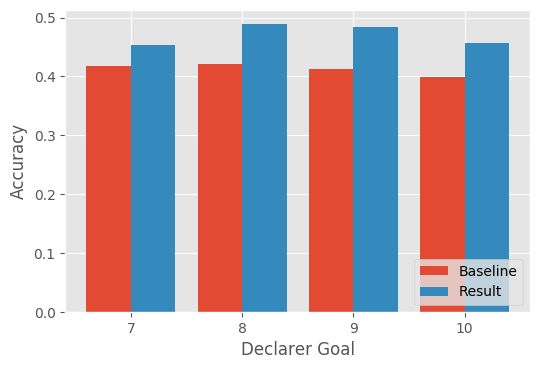

In [91]:
import numpy as np

width = .4
max_goal = 4

plt.figure(dpi=100)
plt.bar(np.arange(max_goal), suit_acc[0], width=width)
plt.bar(np.arange(max_goal) + width, suit_acc[1], width=width)

plt.xticks(np.arange(max_goal) + width / 2, np.arange(max_goal)+7)
plt.legend(['Baseline', 'Result'], loc='lower right')
plt.xlabel('Declarer Goal')
plt.ylabel('Accuracy')

plt.show()

In [92]:
bidding_len = biddings.sum(dim=1).sum(dim=1)
lengths = np.arange(bidding_len.min(), bidding_len.max()+1)
bidding_len.unique(return_counts=True)

(tensor([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.]),
 tensor([1751, 1558,  868,  851, 1088,  875,  765,  673,  654,  607,  160,  150]))

In [93]:
len_acc = [[] for i in range(2)]
for i, r in enumerate([random_results, hinted_results]):
    for l in lengths:
        len_acc[i].append(((torch.stack((r == targets)[bidding_len==l, :].split(52, dim=1)).sum(dim=0)) == 4).float().mean(dim=1).mean().item())
# len_acc

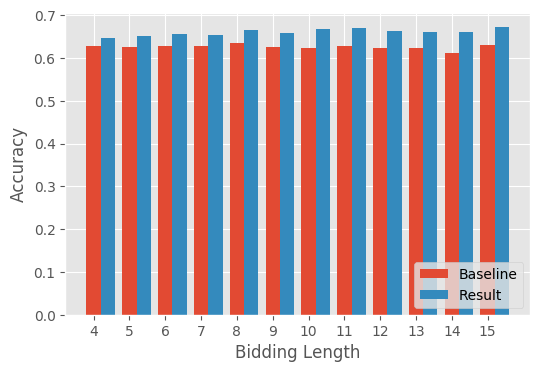

In [101]:
width = .4
max_cnt = 12
plt.figure(dpi=100)
for i, acc in enumerate(len_acc):
    plt.bar(np.arange(max_cnt) + width*i, acc[:max_cnt], width=width)
plt.xticks(np.arange(max_cnt), np.arange(max_cnt)+4)
plt.legend(['Baseline', 'Result'], loc='lower right')
plt.xlabel('Bidding Length')
plt.ylabel('Accuracy')
plt.show()

In [102]:
player_suit_cnt = torch.stack(torch.stack(targets.split(52, dim=1), dim=1).split(13, dim=2), dim=2).sum(dim=3)
unknown_player_suit = torch.stack(torch.stack((hints == 0).split(52, dim=1), dim=1).any(dim=2).repeat(1, 4).split(4, dim=1), dim=2)

suit_cnt_mse = [[] for i in range(2)]
for i, r in enumerate([random_results, hinted_results]):
    pred_player_suit_cnt = torch.stack(torch.stack(r.split(52, dim=1), dim=1).split(13, dim=2), dim=2).sum(dim=3)
    for cnt in range(0, 13+1):
        suit_cnt_mse[i].append(((player_suit_cnt[player_suit_cnt==cnt] - pred_player_suit_cnt[player_suit_cnt==cnt])[unknown_player_suit[player_suit_cnt==cnt]] ** 2).nanmean().item())

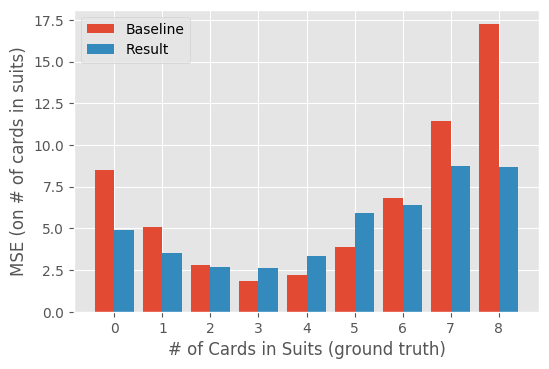

In [103]:
width = .4
max_cnt = 9
plt.figure(dpi=100)
for i, mse in enumerate(suit_cnt_mse):
    plt.bar(np.arange(max_cnt) + width*i, mse[:max_cnt], width=width)
plt.xticks(np.arange(max_cnt) + width / 2, np.arange(max_cnt))
plt.legend(['Baseline', 'Result'])
plt.xlabel('# of Cards in Suits (ground truth)')
plt.ylabel('MSE (on # of cards in suits)')
plt.show()